### Setup the Environment and Load the Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import nest_asyncio
import plotly.graph_objs as go
nest_asyncio.apply()

# Load the demographics data
demo_data = pd.read_csv('../data_r_1/demographics.csv')

# Load the infection history data for r=1
time_data_r1 = pd.read_csv('../data_r_1/inf_status_history.csv')
true_rt_df_r1 = pd.read_csv('../data_r_1/secondary_infections.csv')
true_rt_r1 = true_rt_df_r1['R_t'].values

# Load the infection history data for r=0.2
time_data_r02 = pd.read_csv('../data_r_02/inf_status_history.csv')
true_rt_df_r02 = pd.read_csv('../data_r_02/secondary_infections.csv')
true_rt_r02 = true_rt_df_r02['R_t'].values

In [4]:
# Get the initial infection
initial_infection_time = time_data_r1.iloc[0, 1:].value_counts().get(3, 0)
initial_infection_time += time_data_r1.iloc[0, 1:].value_counts().get(4, 0)
initial_infection_time += time_data_r1.iloc[0, 1:].value_counts().get(5, 0)
initial_infection_time += time_data_r1.iloc[0, 1:].value_counts().get(6, 0)
initial_infection_time += time_data_r1.iloc[0, 1:].value_counts().get(7, 0)
initial_infection_time += time_data_r1.iloc[0, 1:].value_counts().get(8, 0)

### Read True Incidences from Output of EpiABM

/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/ipykernel_53276/2039610545.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[i] == 1:


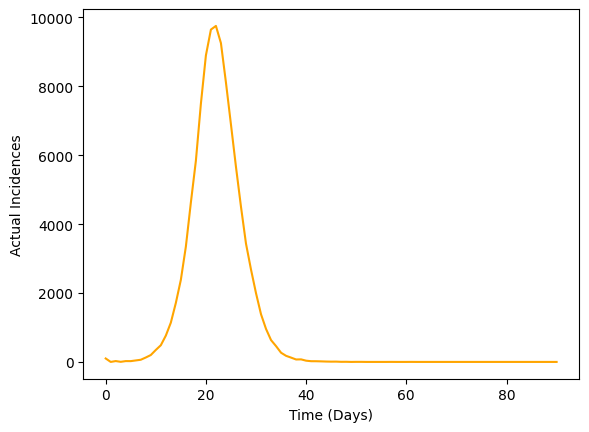

In [ ]:
# Generate the incidences of the true infection data
incidences_true_r1 = []
for ind, row in time_data_r1.iterrows():
    if ind < len(time_data_r1) - 1:
        incidence = 0
        element_zero = []
        for i in range(1, len(row)):
            if row[i] == 1:
                element_zero.append(i)
        if len(element_zero) > 0:
            for i in element_zero:
                if time_data_r1.iloc[ind + 1, i] > 2 and time_data_r1.iloc[ind + 1, i] < 9:
                    incidence += 1
        incidences_true_r1.append(incidence)
    else:
        break
incidences_true_r1.insert(0, initial_infection_time)
plt.figure()
plt.plot(incidences_true_r1, color='orange')
plt.xlabel('Time (Days)')
plt.ylabel('Actual Incidences')
plt.show()

/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/ipykernel_53276/225753468.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



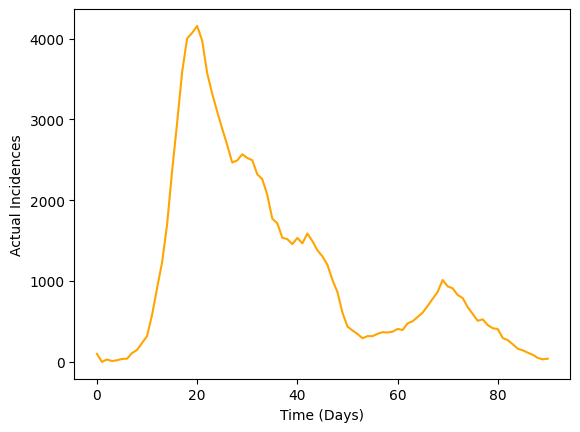

In [14]:
# Generate the incidences of the true infection data
incidences_true_r02 = []
for ind, row in time_data_r02.iterrows():
    if ind < len(time_data_r02) - 1:
        incidence = 0
        element_zero = []
        for i in range(1, len(row)):
            if row[i] == 1:
                element_zero.append(i)
        if len(element_zero) > 0:
            for i in element_zero:
                if time_data_r02.iloc[ind + 1, i] > 2 and time_data_r02.iloc[ind + 1, i] < 9:
                    incidence += 1
        incidences_true_r02.append(incidence)
    else:
        break
incidences_true_r02.insert(0, initial_infection_time)
plt.figure()
plt.plot(incidences_true_r02, color='orange')
plt.xlabel('Time (Days)')
plt.ylabel('Actual Incidences')
plt.show()

### Calculate the serial interval and generation time from the synthetic data

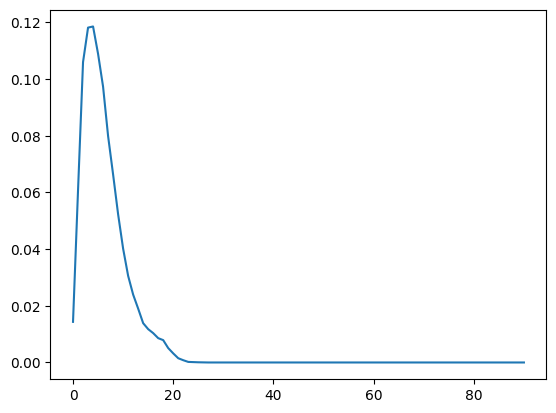

In [11]:
# Average serial interval from the secondary infection file
serial_interval_df = pd.read_csv('../simulation_outputs/serial_intervals.csv').values
serial_interval_emp = serial_interval_df[~np.isnan(serial_interval_df)]

from collections import Counter

counts = Counter(serial_interval_emp)

# Compute probabilities
total_count = sum(counts.values())
probabilities = {k: v / total_count for k, v in counts.items()}

serial_interval_emp = np.zeros(serial_interval_df.shape[1])
for k, v in probabilities.items():
    serial_interval_emp[int(k) - 1] = v
plt.figure()
plt.plot(serial_interval_emp)
plt.show()

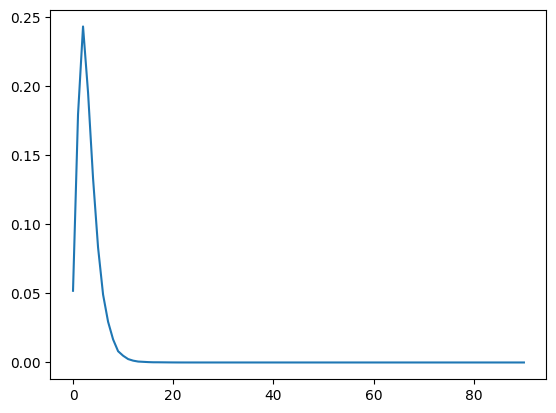

In [25]:
# Generate the generation time
generation_time_df = pd.read_csv('../data_r_1/generation_times (1).csv').values
generation_time_emp = generation_time_df[~np.isnan(generation_time_df)]

from collections import Counter

counts = Counter(generation_time_emp)

# Compute probabilities
total_count = sum(counts.values())
probabilities = {k: v / total_count for k, v in counts.items()}

generation_time_emp = np.zeros(generation_time_df.shape[1])
for k, v in probabilities.items():
    generation_time_emp[int(k) - 1] = v
plt.figure()
plt.plot(generation_time_emp)
plt.show()

### Make the $R_t$ prediction using Serial intervals

In [45]:
import scipy.integrate as si
def Rt_inst_to_Rt_case(Rt_inst, f, t_start, t_end):
    """Converts the instantaneous reproduction number to the case reproduction number
    at time t, given a generation time/serial interval distribution, f.
    """
    Rt_case = []
    dx = 1
    for t in range(t_end - t_start):
        Rt_case_t = si.simpson(Rt_inst[t:] * (f[:t_end-t_start-t]), x=np.arange(t + t_start, t_end, 1.0))
        Rt_case.append(Rt_case_t)
    return Rt_case

In [49]:
# Use incidence data to predict R_t value
theta = incidences_true_r1
starting_time_point = 0
end_time_point = len(theta)
# Define variables needed for calculating R_t
tau = 0
R_t_start = tau+1
a = 1
b = 1/5

serial_interval = serial_interval_emp

# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)-2),
        'Incidence Number': incidences_true_r1[2:len(theta)]
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()
interval_mean = intervals['Mean'].to_numpy()
interval_lower = intervals['Lower bound CI'].to_numpy()
interval_upper = intervals['Upper bound CI'].to_numpy()
interval_mean = Rt_inst_to_Rt_case(interval_mean, generation_time_emp, 0, len(interval_mean))
interval_lower = Rt_inst_to_Rt_case(interval_lower, generation_time_emp, 0, len(interval_mean))
interval_upper = Rt_inst_to_Rt_case(interval_upper, generation_time_emp, 0, len(interval_mean))
intervals['Mean'] = interval_mean
intervals['Lower bound CI'] = interval_lower
intervals['Upper bound CI'] = interval_upper

# fig.add_interval_true_rt(intervals_true)  # Here I used a modified version of branchpro method to plot the true R_t
fig.add_interval_rt(intervals)
true_rt_plot = go.Scatter(
    y=true_rt_r1[starting_time_point:end_time_point],
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Actual R_t',
    line_color='green'
)

fig.figure.add_trace(true_rt_plot)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

In [50]:
# Use incidence data to predict R_t value
theta = incidences_true_r02
starting_time_point = 0
end_time_point = len(theta)
# Define variables needed for calculating R_t
tau = 0
R_t_start = tau+1
a = 1
b = 1/5

serial_interval = serial_interval_emp

# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)-2),
        'Incidence Number': incidences_true_r02[2:len(theta)]
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()
interval_mean = intervals['Mean'].to_numpy()
interval_lower = intervals['Lower bound CI'].to_numpy()
interval_upper = intervals['Upper bound CI'].to_numpy()
interval_mean = Rt_inst_to_Rt_case(interval_mean, generation_time_emp, 0, len(interval_mean))
interval_lower = Rt_inst_to_Rt_case(interval_lower, generation_time_emp, 0, len(interval_mean))
interval_upper = Rt_inst_to_Rt_case(interval_upper, generation_time_emp, 0, len(interval_mean))
intervals['Mean'] = interval_mean
intervals['Lower bound CI'] = interval_lower
intervals['Upper bound CI'] = interval_upper

# fig.add_interval_true_rt(intervals_true)  # Here I used a modified version of branchpro method to plot the true R_t
fig.add_interval_rt(intervals)
true_rt_plot = go.Scatter(
    y=true_rt_r02[starting_time_point:end_time_point],
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Actual R_t',
    line_color='green'
)

fig.figure.add_trace(true_rt_plot)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

### Estimation of Serial interval by keeping track of a group of people (Supplementary Materials 5)

Text(0, 0.5, 'Frequency')

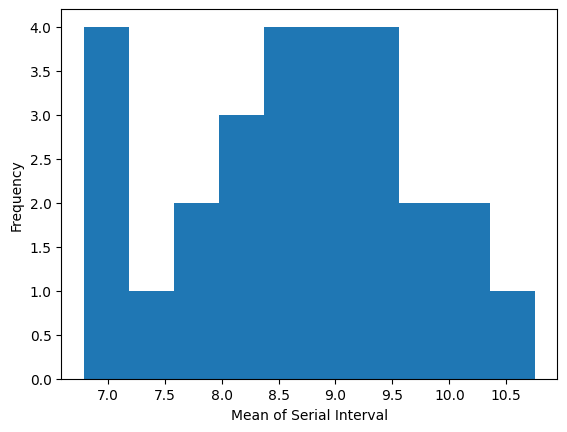

In [ ]:
from tqdm import tqdm
time_sample=list(range(0, 81, 10))
def serial_interval_estimation(time_data, time_sample, max_sample_size, replicate=1):
    total_length = len(time_data)
    infected_condition = lambda x: x in [3, 4, 5, 6, 7, 8]
    mean_serial_interval_list = []
    std_serial_interval_list = []
    for i in range(replicate):
        with tqdm(total=len(time_sample), desc=f'Replicate {i}') as pbar:
            mean_serial_interval = []
            std_serial_interval = []
            for time in time_sample:
                time_specific_serial_interval = []
                row = time_data.iloc[time]
                patient_pool = row[row.apply(infected_condition)].index.tolist()
                row_prev = time_data.iloc[time - 1]
                patient_pool_prev = row_prev[row_prev.apply(infected_condition)].index.tolist()
                patient_pool = list(set(patient_pool) - set(patient_pool_prev))
                selected_people = np.random.choice(patient_pool, min(max_sample_size, len(patient_pool)), replace=False)
                for people in selected_people:
                    done = False
                    infected_length = 1
                    curr_time = time
                    close_contact_condition = lambda x: '.'.join(x.split('.')[:-2]) == '.'.join(people.split('.')[:-2])
                    close_contacts = time_data.columns[time_data.columns.map(close_contact_condition)].tolist()
                    del close_contacts[close_contacts.index(people)]
                    while not done:
                        if time_data.loc[float(curr_time), people] in [3, 4, 5, 6, 7, 8]:
                            if curr_time >= total_length - 1:
                                done = True
                            else:
                                done = False
                                infected_length += 1
                                curr_time += 1
                        else:
                            done = True
                    for t in range(1, infected_length):
                        for contact in close_contacts:
                            if time_data.loc[float(time + t), contact] in [3, 4, 5, 6, 7, 8]:
                                serial_interval = t
                                break
                    time_specific_serial_interval.append(serial_interval)
                pbar.update(1)
                mean_serial_interval.append(np.mean(time_specific_serial_interval))
                std_serial_interval.append(np.std(time_specific_serial_interval))
            mean_serial_interval_list.append(mean_serial_interval)
            std_serial_interval_list.append(std_serial_interval)
    return mean_serial_interval_list, std_serial_interval_list
pred_mean, pred_std = serial_interval_estimation(time_data=time_data_r1, time_sample=time_sample, max_sample_size=100, replicate=1)
plt.hist(np.array(pred_mean).reshape((1, -1))[0], bins=10)
plt.xlabel('Mean of Serial Interval')
plt.ylabel('Frequency')

9.23 6.34799968494013


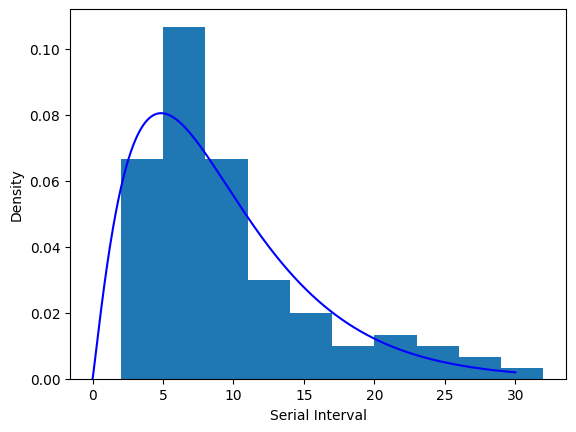

In [ ]:
from tqdm import tqdm
time_sample=list(range(0, 81, 10))
def serial_interval_estimation_single(time_data, time_sample, max_sample_size):
    total_length = len(time_data)
    infected_condition = lambda x: x in [3, 4, 5, 6, 7, 8]
    time = time_sample
    time_specific_serial_interval = []
    row = time_data.iloc[time]
    patient_pool = row[row.apply(infected_condition)].index.tolist()
    row_prev = time_data.iloc[time - 1]
    patient_pool_prev = row_prev[row_prev.apply(infected_condition)].index.tolist()
    patient_pool = list(set(patient_pool) - set(patient_pool_prev))
    selected_people = np.random.choice(patient_pool, min(max_sample_size, len(patient_pool)), replace=False)
    for people in selected_people:
        done = False
        infected_length = 1
        curr_time = time
        close_contact_condition = lambda x: '.'.join(x.split('.')[:-2]) == '.'.join(people.split('.')[:-2])
        close_contacts = time_data.columns[time_data.columns.map(close_contact_condition)].tolist()
        del close_contacts[close_contacts.index(people)]
        while not done:
            if time_data.loc[float(curr_time), people] in [3, 4, 5, 6, 7, 8]:
                if curr_time >= total_length - 1:
                    done = True
                else:
                    done = False
                    infected_length += 1
                    curr_time += 1
            else:
                done = True
        for t in range(1, infected_length):
            for contact in close_contacts:
                if time_data.loc[float(time + t), contact] in [3, 4, 5, 6, 7, 8]:
                    serial_interval = t
                    break
        time_specific_serial_interval.append(serial_interval)
    return time_specific_serial_interval
serial_interval_single = serial_interval_estimation_single(time_data=time_data_r1, time_sample=30, max_sample_size=100)

mean_single = np.mean(serial_interval_single)
std_single = np.std(serial_interval_single)
print(mean_single, std_single)
plt.figure()

plt.hist(serial_interval_single, bins=10, density=True)
from scipy.stats import gamma

mean = mean_single
variance = std_single**2

k = mean**2 / variance
theta = variance / mean

x = np.linspace(0, 30, 1000)

pdf = gamma.pdf(x, a=k, scale=theta)
plt.plot(x, pdf, c='b')
plt.xlabel('Serial Interval')
plt.ylabel('Density')
plt.show()

### Sensitivity Analysis of Serial Interval in the Renewal Model (Supplementary Material 6)

In [ ]:
def r_t_inference(inc_data, serial_interval, actual_rt, tau=0, a=1, b=1/5, warm_up=3):
    # Use incidence data to predict R_t value

    # Define variables needed for calculating R_t
    tau = tau
    R_t_start = tau+1
    a = a
    b = b


    if isinstance(serial_interval, tuple):
        ws_mean = serial_interval[0]
        ws_var = serial_interval[1] ** 2

        theta_num = ws_var / ws_mean
        k = ws_mean / theta_num
        w_dist = scipy.stats.gamma(k, scale=theta_num)
        disc_w = w_dist.pdf(range(len(theta)))
        serial_interval = disc_w
        serial_interval = serial_interval[1:]
    else:
        serial_interval = serial_interval

    # Plot comparison between the true and predicted R_t
    # Transform our incidence data into pandas dataframes
    inc_data = pd.DataFrame(
        {
            'Time': np.arange(len(inc_data)),
            'Incidence Number': inc_data
        }
    )

    inference = branchpro.BranchProPosterior(
        inc_data=inc_data,
        daily_serial_interval=serial_interval,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    pred = intervals['Mean'].to_numpy()
    rmse = np.sqrt(np.mean((pred[warm_up - 1:] - actual_rt[warm_up:]) ** 2))
    return rmse

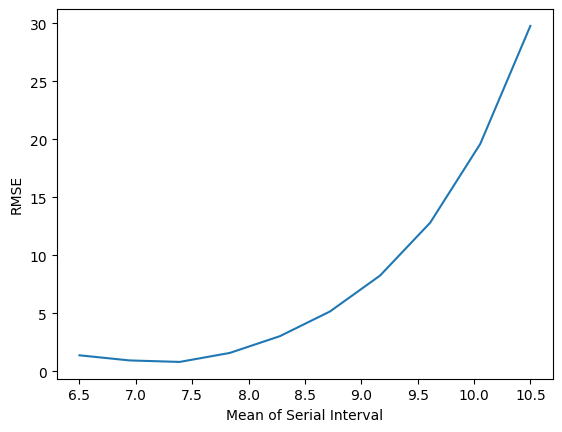

In [ ]:
rmse_list = []
si_mean = np.linspace(6.5, 10.5, 10)
si_std = 4
si_list = [(mean, si_std) for mean in si_mean]
for si in si_list:
    rmse_list.append(r_t_inference(incidences_true_r1, si, true_rt_r1, tau=0, a=1, b=1/5, warm_up=3))
plt.figure()
plt.plot(si_mean, rmse_list)
plt.xlabel('Mean of Serial Interval')
plt.ylabel('RMSE')
plt.show()

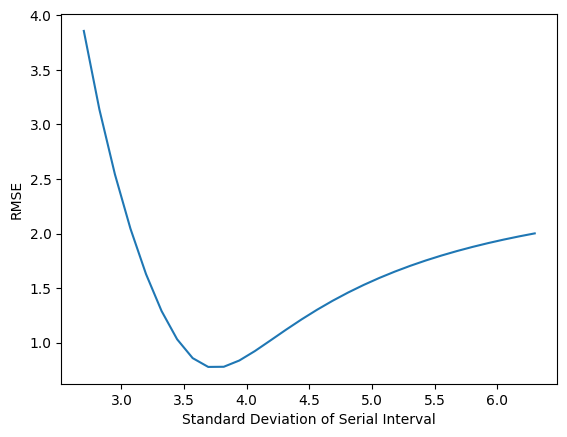

In [ ]:
rmse_list = []
si_mean = 7
si_std = np.linspace(2.7, 6.3, 30)
si_list = [(si_mean, std) for std in si_std]
for si in si_list:
    rmse_list.append(r_t_inference(incidences_true_r1, si, true_rt_r1, tau=0, a=1, b=1/5, warm_up=3))
plt.figure()
plt.plot(si_std, rmse_list)
plt.xlabel('Standard Deviation of Serial Interval')
plt.ylabel('RMSE')
plt.show()